# Install Packages

In [1]:
pip install -e ./lib/quantum_electron-main/quantum_electron-main/

Obtaining file:///C:/Users/LyonLab/Documents/GitHub/LyonLabCodebase/femSims/Gordian/Gordian/lib/quantum_electron-main/quantum_electron-main
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for quantum-electron
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: C:\Users\LyonLab\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
pip install -e ./lib/zeroheliumkit_0.5.0_win/

Obtaining file:///C:/Users/LyonLab/Documents/GitHub/LyonLabCodebase/femSims/Gordian/Gordian/lib/zeroheliumkit_0.5.0_win
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for zeroheliumkit
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: C:\Users\LyonLab\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Imports

In [2]:
pip install svgpathtools

     ---------------------------------------- 68.3/68.3 kB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 67.1/67.1 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: C:\Users\LyonLab\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt

from zeroheliumkit import Structure, Rectangle, GeomCollection
from zeroheliumkit.src.importing import Reader_GDS,Reader_DXF,Reader_Pickle
from zeroheliumkit.fem import *
from zeroheliumkit.src.settings import  *

%matplotlib inline
%config InlineBackend.figure_format='retina'

plot_config = {'wafer':BLACK,'bottom':YELLOW2,'extra':GRAY,'top':(BLUE,0.6)}

# Device Importing

reduced_2.gds // Layers in cell 'TOP': {0, 28, 22}


<AxesSubplot:>

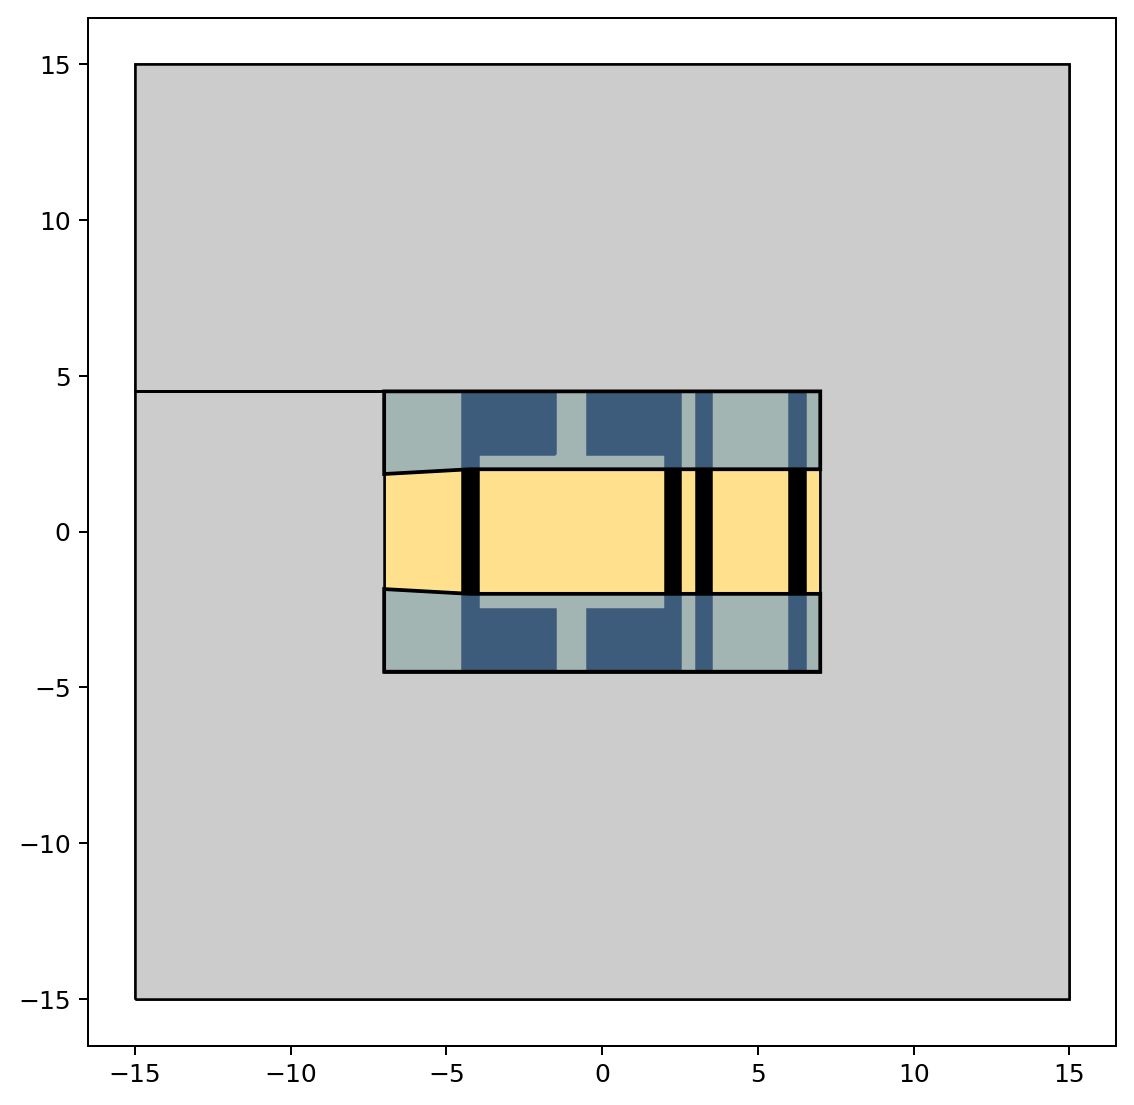

In [41]:
# Read File
file = Reader_GDS('reduced_2.gds')
file.import2zhk("TOP")
device = GeomCollection(file.geometries)

#Add a "wafer" Layer
device.add_layer('wafer', Rectangle(30,30,(0,0)))

# Rename Layers
device.rename_layer('L0','extra')
device.rename_layer('L22','bottom')
device.rename_layer('L28','top')
device.layers

#Show Device
device.quickplot(plot_config)

# Viewing Electrodes

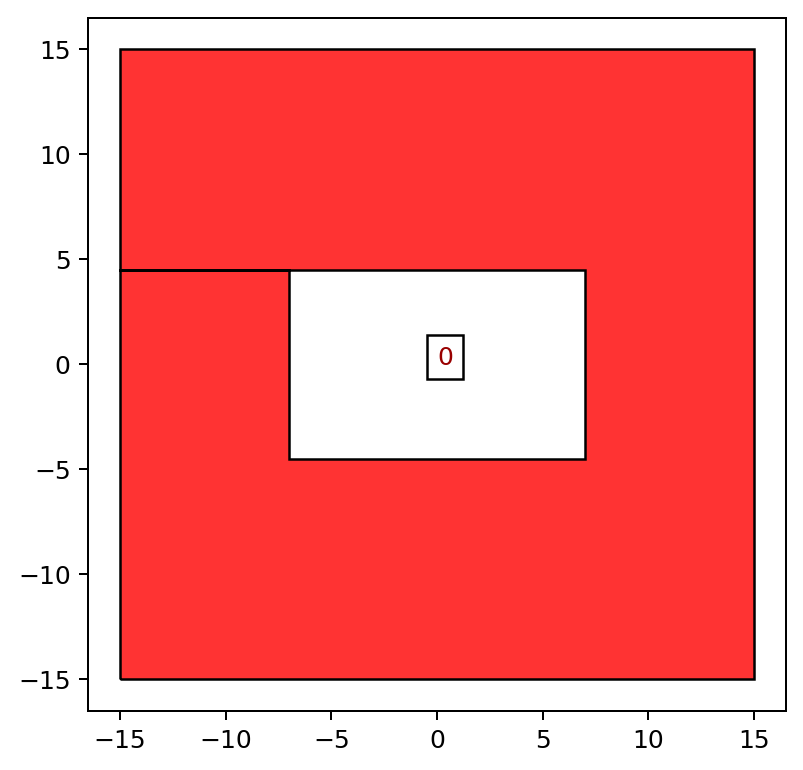

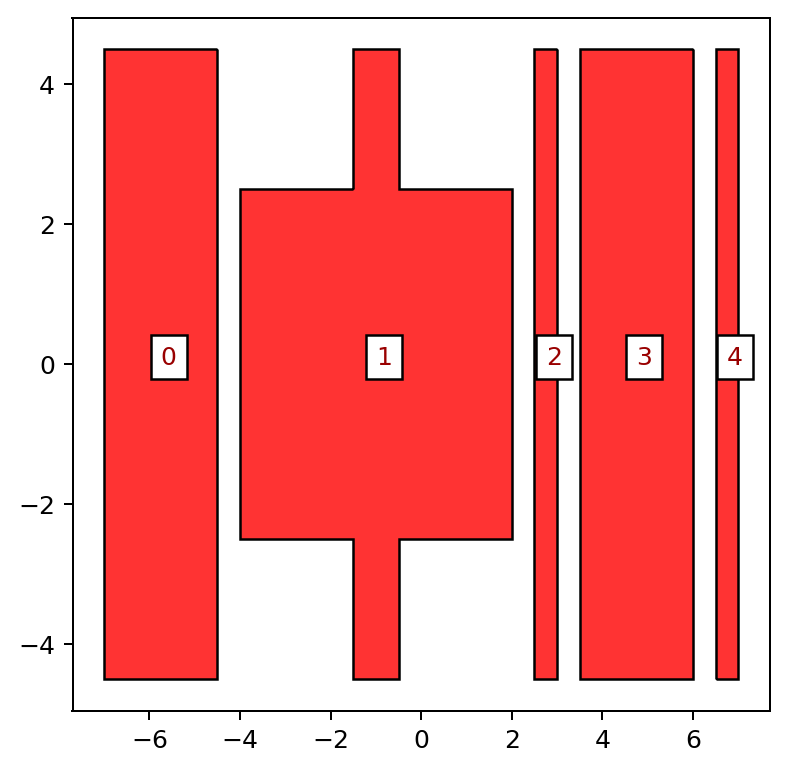

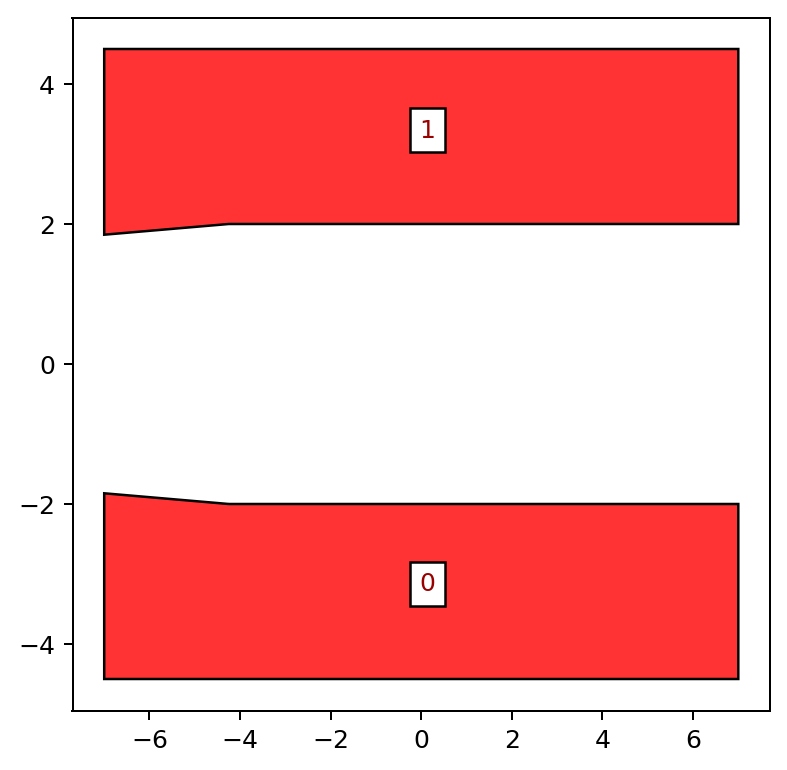

In [42]:
for layer in ["extra","bottom","top"]:
    fig = plt.figure(1, figsize=(5,5), dpi=90)
    ax = fig.add_subplot(111)
    device.plot(ax=ax, layer=[layer],color=[RED],show_idx=True)
    plt.show()

# Define 3D Geometry

In [47]:
d_metal1 = 0.900
d_metal2 = 0.250
d_diel  = 0.900
d_vac   = 25
d_He    = d_diel + d_metal2
d_total = d_metal1 + d_He

extrude_config = {
    'wafer' :       gmshLayer_info('wafer'    , -d_vac/2 , d_vac/2         , 'DIELECTRIC'),
    'bottom':       gmshLayer_info('bottom'   , 0 , d_metal1               , 'METAL'),
    'extra':        gmshLayer_info('extra'    , 0 , d_metal1               , 'METAL'),
    'dielectric':   gmshLayer_info('top'      , d_metal1 , d_diel          , 'DIELECTRIC'),
    'top':          gmshLayer_info('top'      , d_metal1+d_diel, d_metal2  , 'METAL'),
    'helium':       gmshLayer_info('wafer'    , d_metal1, d_He             , 'HELIUM', ('dielectric','top')),
    'vacuum':       gmshLayer_info('wafer'    , d_metal1+d_He, d_vac       , 'VACUUM', ('dielectric', 'top'))
}

electrodes_config = {
    'Door1':        physSurface_info('bottom',   [0], 'bottom'),
    'Sense':        physSurface_info('bottom',   [1], 'bottom'),
    'Guard':        physSurface_info('bottom',   [2], 'bottom'),
    'Twiddle':      physSurface_info('bottom',   [3], 'bottom'),
    'Door2':        physSurface_info('bottom',   [4], 'bottom'),
    'Top':          physSurface_info('top',    [0,1], 'top'),
    'Extra':        physSurface_info('extra',    [0], 'extra'),
}

mediumregion_box = [-12, 12, -5, 5, -0.7, 6]
fineregion_box = [-8, 8, -2.5, 2.5, -0.1, 4.5]
scale = 4
mesh_params = [{"Thickness": 4, "VIn": scale * 0.2, "VOut": .5*scale, "box": mediumregion_box},
               {"Thickness": 2, "VIn": scale * 0.1, "VOut": .5*scale, "box": fineregion_box}
              ]

# Generate Mesh

In [48]:
save_dir = 'dump/'
mshID = 'GordianSensor'
meshMKR =  GMSHmaker(layout=device, 
                     extrude_config=extrude_config, 
                     electrodes_config=electrodes_config, 
                     mesh_params=mesh_params)
meshMKR.create_geo(save_dir+mshID )
meshMKR.create_mesh(save_dir+mshID, dim=3)
meshMKR.open_gmsh()
meshMKR.finalize()

Exception: Curve loop is not closed

# Create edp file

In [46]:
He_level = round(d_total,3)

var_eps = {
        'DIELECTRIC': 11.0,
        'METAL': 1.0,
        'HELIUM': 1.057,
        'VACUUM': 1.0,
}

ff_config ={
    'meshfile': save_dir+mshID,
    'dielectric_constants': var_eps,
    'ff_polynomial': 2,
    'extract_opt': [extract_results('phi', 'xy', (-8, 8,1001), (-2.5, 2.5,201), He_level,'GordianSensor'),
                    ],
    'physicalSurfaces': {k: v.get('group_id') for (k, v) in meshMKR.physicalSurfaces.items()},
    'physicalVolumes': {k: v.get('group_id') for (k, v) in meshMKR.physicalVolumes.items()}
}

with open(save_dir+r'config.yaml', 'w') as file:
    documents = yaml.safe_dump(ff_config, file)

In [45]:
with open(save_dir+r'config.yaml', 'r') as file:
    config = yaml.safe_load(file)

yff = FreeFEM(config=config,
               dirname='./',
               run_from_notebook=False)

Then in a terminal, cd to this folder and run: "freefem++ ./dump/GordianSensor.edp"